In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import os
import os.path as osp
import sys
import time
import glob
import cv2
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

import torchvision
from torchvision import transforms, datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

from dataset import CVATDataset
from dataset import variable_shape_collate_fn


from utils import letterbox_label_reverse, bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh
from draw import show_img, draw_rect, draw_text, \
                 cv2_drawTextWithBkgd, get_color_pallete
from darknet import YoloNet
from train import *

# Paths

In [2]:
weight_path = './yolov3.weights'
backbone_weight_path = './darknet53.conv.74'
classes_path = './x_wing.names'
classes_names = ['x_wing', 'tie']
cvat_img_dir = './custom_data/x_wing'
label_xml_path = './custom_data/7_x_wing.xml'
output_dir = './output'

# Training

## Set up dataloader

In [5]:
def getData(sz, bs):
    dim = (sz, sz)

    train_ds = CVATDataset(cvat_img_dir, label_xml_path, dim=dim)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False, num_workers=4)
    
    dataloader = dict()
    dataloader['train'] = train_dl
    dataloader['valid'] = None
    
    return dataloader

## Initial training

In [12]:
lr = 0.01
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001
yolo_lr = 0.01

In [13]:
epoch = 100
model_id = 'x_wing_2'
weight_dir_path = './weights'

remove_checkpoints(model_id, weight_dir_path)

net = YoloNet((sz, sz)).cuda()
net.feature.loadWeight(backbone_weight_path)

train(getData(sz, bs), net, epoch,
      lr, darknet53_lr, wd, momentum,
      0, 0, #lr_scheduler_decay_step, lr_scheduler_decay_gamma,
      model_id=model_id, start_epoch=0, weight_dir=weight_dir_path, checkpoint_interval=20,
      resume_checkpoint=None, use_gpu=True)

[Epoch:0[1/100], Batch 0/16]
[Losses: x 0.000731, y 0.000722, w 0.000586, h 0.001465, conf 0.064592, cls 0.131964, total 0.200061, recall: 0.08333]
[Epoch:0[1/100], Batch 1/16]
[Losses: x 0.000786, y 0.000799, w 0.000728, h 0.001507, conf 0.064146, cls 0.131822, total 0.199788, recall: 0.07955]
[Epoch:0[1/100], Batch 2/16]
[Losses: x 0.000746, y 0.000753, w 0.000555, h 0.001140, conf 0.063380, cls 0.131561, total 0.198135, recall: 0.10933]
[Epoch:0[1/100], Batch 3/16]
[Losses: x 0.000717, y 0.000721, w 0.000514, h 0.000963, conf 0.062387, cls 0.131363, total 0.196666, recall: 0.12292]
[Epoch:0[1/100], Batch 4/16]
[Losses: x 0.000632, y 0.000634, w 0.000448, h 0.000790, conf 0.061196, cls 0.131348, total 0.195048, recall: 0.11932]
[Epoch:0[1/100], Batch 5/16]
[Losses: x 0.000624, y 0.000628, w 0.000416, h 0.000679, conf 0.059891, cls 0.130449, total 0.192686, recall: 0.14921]
[Epoch:0[1/100], Batch 6/16]
[Losses: x 0.000605, y 0.000609, w 0.000406, h 0.000605, conf 0.058498, cls 0.12914

[Epoch:3[4/100], Batch 8/16]
[Losses: x 0.000720, y 0.000706, w 0.000125, h 0.000268, conf 0.009591, cls 0.009048, total 0.020457, recall: 0.20460]
[Epoch:3[4/100], Batch 9/16]
[Losses: x 0.000713, y 0.000698, w 0.000119, h 0.000251, conf 0.009506, cls 0.008365, total 0.019652, recall: 0.23101]
[Epoch:3[4/100], Batch 10/16]
[Losses: x 0.000689, y 0.000675, w 0.000117, h 0.000234, conf 0.009362, cls 0.007692, total 0.018769, recall: 0.25091]
[Epoch:3[4/100], Batch 11/16]
[Losses: x 0.000676, y 0.000662, w 0.000116, h 0.000226, conf 0.009258, cls 0.007234, total 0.018171, recall: 0.25205]
[Epoch:3[4/100], Batch 12/16]
[Losses: x 0.000710, y 0.000692, w 0.000128, h 0.000223, conf 0.009200, cls 0.007276, total 0.018231, recall: 0.27076]
[Epoch:3[4/100], Batch 13/16]
[Losses: x 0.000728, y 0.000710, w 0.000130, h 0.000217, conf 0.009141, cls 0.007941, total 0.018868, recall: 0.28180]
[Epoch:3[4/100], Batch 14/16]
[Losses: x 0.000709, y 0.000692, w 0.000126, h 0.000211, conf 0.009049, cls 0.

[Epoch:7[8/100], Batch 0/16]
[Losses: x 0.000636, y 0.000632, w 0.000055, h 0.000223, conf 0.004052, cls 0.000866, total 0.006464, recall: 0.14167]
[Epoch:7[8/100], Batch 1/16]
[Losses: x 0.000706, y 0.000692, w 0.000063, h 0.000180, conf 0.004110, cls 0.001043, total 0.006796, recall: 0.21591]
[Epoch:7[8/100], Batch 2/16]
[Losses: x 0.000665, y 0.000661, w 0.000056, h 0.000134, conf 0.003966, cls 0.000995, total 0.006477, recall: 0.31733]
[Epoch:7[8/100], Batch 3/16]
[Losses: x 0.000641, y 0.000639, w 0.000058, h 0.000135, conf 0.004034, cls 0.001059, total 0.006566, recall: 0.30000]
[Epoch:7[8/100], Batch 4/16]
[Losses: x 0.000566, y 0.000562, w 0.000051, h 0.000116, conf 0.004240, cls 0.001159, total 0.006695, recall: 0.31439]
[Epoch:7[8/100], Batch 5/16]
[Losses: x 0.000560, y 0.000563, w 0.000048, h 0.000145, conf 0.004174, cls 0.001088, total 0.006578, recall: 0.33016]
[Epoch:7[8/100], Batch 6/16]
[Losses: x 0.000543, y 0.000545, w 0.000044, h 0.000155, conf 0.004087, cls 0.00100

[Epoch:10[11/100], Batch 8/16]
[Losses: x 0.000646, y 0.000642, w 0.000080, h 0.000215, conf 0.003043, cls 0.000930, total 0.005555, recall: 0.27962]
[Epoch:10[11/100], Batch 9/16]
[Losses: x 0.000640, y 0.000633, w 0.000086, h 0.000217, conf 0.002998, cls 0.000886, total 0.005460, recall: 0.29225]
[Epoch:10[11/100], Batch 10/16]
[Losses: x 0.000617, y 0.000611, w 0.000092, h 0.000206, conf 0.002936, cls 0.000833, total 0.005295, recall: 0.30708]
[Epoch:10[11/100], Batch 11/16]
[Losses: x 0.000605, y 0.000598, w 0.000099, h 0.000192, conf 0.002898, cls 0.000794, total 0.005186, recall: 0.31148]
[Epoch:10[11/100], Batch 12/16]
[Losses: x 0.000637, y 0.000627, w 0.000106, h 0.000181, conf 0.002926, cls 0.000848, total 0.005325, recall: 0.34416]
[Epoch:10[11/100], Batch 13/16]
[Losses: x 0.000653, y 0.000642, w 0.000105, h 0.000174, conf 0.002969, cls 0.001286, total 0.005829, recall: 0.35910]
[Epoch:10[11/100], Batch 14/16]
[Losses: x 0.000635, y 0.000626, w 0.000099, h 0.000174, conf 0.

[Epoch:13[14/100], Batch 15/16]
[Losses: x 0.000731, y 0.000722, w 0.000873, h 0.001761, conf 0.002593, cls 0.001820, total 0.008499, recall: 0.33433]
[Epoch:14[15/100], Batch 0/16]
[Losses: x 0.000615, y 0.000618, w 0.000658, h 0.000152, conf 0.002190, cls 0.000621, total 0.004853, recall: 0.14167]
[Epoch:14[15/100], Batch 1/16]
[Losses: x 0.000677, y 0.000673, w 0.000378, h 0.000398, conf 0.002269, cls 0.000866, total 0.005261, recall: 0.20455]
[Epoch:14[15/100], Batch 2/16]
[Losses: x 0.000636, y 0.000642, w 0.000275, h 0.001010, conf 0.002192, cls 0.000929, total 0.005684, recall: 0.26133]
[Epoch:14[15/100], Batch 3/16]
[Losses: x 0.000614, y 0.000614, w 0.000286, h 0.001560, conf 0.002257, cls 0.001017, total 0.006348, recall: 0.26458]
[Epoch:14[15/100], Batch 4/16]
[Losses: x 0.000542, y 0.000541, w 0.000248, h 0.001369, conf 0.002336, cls 0.001145, total 0.006181, recall: 0.28598]
[Epoch:14[15/100], Batch 5/16]
[Losses: x 0.000537, y 0.000542, w 0.000383, h 0.002259, conf 0.0023

[Epoch:17[18/100], Batch 6/16]
[Losses: x 0.000529, y 0.000534, w 0.000377, h 0.000804, conf 0.001941, cls 0.001169, total 0.005353, recall: 0.35425]
[Epoch:17[18/100], Batch 7/16]
[Losses: x 0.000562, y 0.000559, w 0.000363, h 0.000714, conf 0.001980, cls 0.001252, total 0.005431, recall: 0.34130]
[Epoch:17[18/100], Batch 8/16]
[Losses: x 0.000650, y 0.000644, w 0.000359, h 0.000685, conf 0.002078, cls 0.001389, total 0.005805, recall: 0.32055]
[Epoch:17[18/100], Batch 9/16]
[Losses: x 0.000644, y 0.000637, w 0.000347, h 0.000697, conf 0.002042, cls 0.001312, total 0.005679, recall: 0.33256]
[Epoch:17[18/100], Batch 10/16]
[Losses: x 0.000621, y 0.000615, w 0.000367, h 0.000736, conf 0.001994, cls 0.001226, total 0.005559, recall: 0.34427]
[Epoch:17[18/100], Batch 11/16]
[Losses: x 0.000609, y 0.000601, w 0.000395, h 0.000765, conf 0.001965, cls 0.001155, total 0.005489, recall: 0.34631]
[Epoch:17[18/100], Batch 12/16]
[Losses: x 0.000639, y 0.000630, w 0.000453, h 0.000770, conf 0.00

[Epoch:20[21/100], Batch 13/16]
[Losses: x 0.000624, y 0.000615, w 0.000365, h 0.000120, conf 0.001699, cls 0.000801, total 0.004225, recall: 0.41064]
[Epoch:20[21/100], Batch 14/16]
[Losses: x 0.000607, y 0.000600, w 0.000342, h 0.000115, conf 0.001678, cls 0.000813, total 0.004156, recall: 0.42166]
[Epoch:20[21/100], Batch 15/16]
[Losses: x 0.000710, y 0.000700, w 0.000340, h 0.000122, conf 0.001838, cls 0.001128, total 0.004838, recall: 0.43049]
[Epoch:21[22/100], Batch 0/16]
[Losses: x 0.000586, y 0.000610, w 0.000268, h 0.000073, conf 0.001483, cls 0.000335, total 0.003355, recall: 0.23333]
[Epoch:21[22/100], Batch 1/16]
[Losses: x 0.000651, y 0.000657, w 0.000475, h 0.000066, conf 0.001553, cls 0.000395, total 0.003797, recall: 0.25758]
[Epoch:21[22/100], Batch 2/16]
[Losses: x 0.000610, y 0.000623, w 0.000581, h 0.000088, conf 0.001497, cls 0.000386, total 0.003786, recall: 0.30133]
[Epoch:21[22/100], Batch 3/16]
[Losses: x 0.000588, y 0.000595, w 0.000599, h 0.000148, conf 0.00

[Epoch:24[25/100], Batch 4/16]
[Losses: x 0.000515, y 0.000519, w 0.001215, h 0.000172, conf 0.001384, cls 0.000443, total 0.004248, recall: 0.36174]
[Epoch:24[25/100], Batch 5/16]
[Losses: x 0.000511, y 0.000520, w 0.001026, h 0.000155, conf 0.001377, cls 0.000474, total 0.004063, recall: 0.40794]
[Epoch:24[25/100], Batch 6/16]
[Losses: x 0.000496, y 0.000505, w 0.000883, h 0.000136, conf 0.001349, cls 0.000478, total 0.003847, recall: 0.44351]
[Epoch:24[25/100], Batch 7/16]
[Losses: x 0.000526, y 0.000525, w 0.000792, h 0.000126, conf 0.001393, cls 0.000536, total 0.003898, recall: 0.44937]
[Epoch:24[25/100], Batch 8/16]
[Losses: x 0.000609, y 0.000604, w 0.000799, h 0.000123, conf 0.001491, cls 0.000645, total 0.004271, recall: 0.40494]
[Epoch:24[25/100], Batch 9/16]
[Losses: x 0.000604, y 0.000597, w 0.000815, h 0.000116, conf 0.001470, cls 0.000615, total 0.004216, recall: 0.40775]
[Epoch:24[25/100], Batch 10/16]
[Losses: x 0.000582, y 0.000576, w 0.000856, h 0.000118, conf 0.0014

[Epoch:27[28/100], Batch 11/16]
[Losses: x 0.000560, y 0.000555, w 0.000542, h 0.000092, conf 0.001248, cls 0.000409, total 0.003406, recall: 0.45423]
[Epoch:27[28/100], Batch 12/16]
[Losses: x 0.000588, y 0.000583, w 0.000522, h 0.000093, conf 0.001266, cls 0.000429, total 0.003481, recall: 0.46450]
[Epoch:27[28/100], Batch 13/16]
[Losses: x 0.000602, y 0.000595, w 0.000512, h 0.000091, conf 0.001291, cls 0.000570, total 0.003661, recall: 0.46711]
[Epoch:27[28/100], Batch 14/16]
[Losses: x 0.000586, y 0.000581, w 0.000489, h 0.000089, conf 0.001276, cls 0.000562, total 0.003583, recall: 0.46845]
[Epoch:27[28/100], Batch 15/16]
[Losses: x 0.000686, y 0.000679, w 0.000576, h 0.000108, conf 0.001441, cls 0.000778, total 0.004268, recall: 0.46637]
[Epoch:28[29/100], Batch 0/16]
[Losses: x 0.000567, y 0.000599, w 0.000052, h 0.000066, conf 0.001083, cls 0.000367, total 0.002733, recall: 0.53333]
[Epoch:28[29/100], Batch 1/16]
[Losses: x 0.000629, y 0.000643, w 0.000129, h 0.000051, conf 0.

[Epoch:31[32/100], Batch 2/16]
[Losses: x 0.000581, y 0.000605, w 0.000099, h 0.000079, conf 0.001024, cls 0.000215, total 0.002602, recall: 0.51200]
[Epoch:31[32/100], Batch 3/16]
[Losses: x 0.000561, y 0.000573, w 0.000136, h 0.000072, conf 0.001057, cls 0.000222, total 0.002621, recall: 0.48125]
[Epoch:31[32/100], Batch 4/16]
[Losses: x 0.000496, y 0.000504, w 0.000124, h 0.000063, conf 0.001044, cls 0.000228, total 0.002460, recall: 0.49053]
[Epoch:31[32/100], Batch 5/16]
[Losses: x 0.000491, y 0.000506, w 0.000156, h 0.000061, conf 0.001043, cls 0.000221, total 0.002479, recall: 0.49365]
[Epoch:31[32/100], Batch 6/16]
[Losses: x 0.000477, y 0.000492, w 0.000178, h 0.000061, conf 0.001028, cls 0.000206, total 0.002442, recall: 0.50349]
[Epoch:31[32/100], Batch 7/16]
[Losses: x 0.000506, y 0.000510, w 0.000193, h 0.000063, conf 0.001082, cls 0.000234, total 0.002588, recall: 0.49261]
[Epoch:31[32/100], Batch 8/16]
[Losses: x 0.000586, y 0.000585, w 0.000196, h 0.000064, conf 0.00116

[Epoch:34[35/100], Batch 9/16]
[Losses: x 0.000576, y 0.000574, w 0.000192, h 0.000083, conf 0.001074, cls 0.000241, total 0.002739, recall: 0.48915]
[Epoch:34[35/100], Batch 10/16]
[Losses: x 0.000556, y 0.000554, w 0.000185, h 0.000081, conf 0.001053, cls 0.000224, total 0.002653, recall: 0.49526]
[Epoch:34[35/100], Batch 11/16]
[Losses: x 0.000543, y 0.000543, w 0.000178, h 0.000080, conf 0.001041, cls 0.000212, total 0.002597, recall: 0.49863]
[Epoch:34[35/100], Batch 12/16]
[Losses: x 0.000570, y 0.000570, w 0.000175, h 0.000082, conf 0.001052, cls 0.000224, total 0.002672, recall: 0.51625]
[Epoch:34[35/100], Batch 13/16]
[Losses: x 0.000584, y 0.000581, w 0.000174, h 0.000080, conf 0.001065, cls 0.000301, total 0.002785, recall: 0.52577]
[Epoch:34[35/100], Batch 14/16]
[Losses: x 0.000569, y 0.000567, w 0.000165, h 0.000077, conf 0.001049, cls 0.000293, total 0.002720, recall: 0.53312]
[Epoch:34[35/100], Batch 15/16]
[Losses: x 0.000667, y 0.000664, w 0.000176, h 0.000083, conf 0

[Epoch:38[39/100], Batch 0/16]
[Losses: x 0.000548, y 0.000587, w 0.000413, h 0.000352, conf 0.000980, cls 0.000144, total 0.003023, recall: 0.36667]
[Epoch:38[39/100], Batch 1/16]
[Losses: x 0.000611, y 0.000630, w 0.000447, h 0.000379, conf 0.001022, cls 0.000170, total 0.003259, recall: 0.38258]
[Epoch:38[39/100], Batch 2/16]
[Losses: x 0.000571, y 0.000598, w 0.000393, h 0.000327, conf 0.000980, cls 0.000164, total 0.003033, recall: 0.42133]
[Epoch:38[39/100], Batch 3/16]
[Losses: x 0.000551, y 0.000565, w 0.000339, h 0.000271, conf 0.000970, cls 0.000172, total 0.002868, recall: 0.42083]
[Epoch:38[39/100], Batch 4/16]
[Losses: x 0.000487, y 0.000496, w 0.000275, h 0.000221, conf 0.000924, cls 0.000177, total 0.002581, recall: 0.43939]
[Epoch:38[39/100], Batch 5/16]
[Losses: x 0.000483, y 0.000499, w 0.000235, h 0.000189, conf 0.000899, cls 0.000180, total 0.002485, recall: 0.50159]
[Epoch:38[39/100], Batch 6/16]
[Losses: x 0.000469, y 0.000485, w 0.000203, h 0.000164, conf 0.00087

[Epoch:41[42/100], Batch 7/16]
[Losses: x 0.000494, y 0.000500, w 0.000191, h 0.000141, conf 0.000857, cls 0.000188, total 0.002371, recall: 0.54494]
[Epoch:41[42/100], Batch 8/16]
[Losses: x 0.000572, y 0.000574, w 0.000241, h 0.000179, conf 0.000945, cls 0.000241, total 0.002752, recall: 0.48849]
[Epoch:41[42/100], Batch 9/16]
[Losses: x 0.000568, y 0.000567, w 0.000233, h 0.000177, conf 0.000936, cls 0.000228, total 0.002709, recall: 0.49147]
[Epoch:41[42/100], Batch 10/16]
[Losses: x 0.000548, y 0.000548, w 0.000216, h 0.000166, conf 0.000915, cls 0.000212, total 0.002605, recall: 0.50109]
[Epoch:41[42/100], Batch 11/16]
[Losses: x 0.000536, y 0.000536, w 0.000200, h 0.000154, conf 0.000897, cls 0.000202, total 0.002525, recall: 0.52049]
[Epoch:41[42/100], Batch 12/16]
[Losses: x 0.000562, y 0.000563, w 0.000187, h 0.000144, conf 0.000897, cls 0.000213, total 0.002566, recall: 0.56197]
[Epoch:41[42/100], Batch 13/16]
[Losses: x 0.000576, y 0.000574, w 0.000180, h 0.000139, conf 0.0

[Epoch:44[45/100], Batch 14/16]
[Losses: x 0.000558, y 0.000557, w 0.000098, h 0.000124, conf 0.000843, cls 0.000234, total 0.002415, recall: 0.60463]
[Epoch:44[45/100], Batch 15/16]
[Losses: x 0.000656, y 0.000652, w 0.000101, h 0.000128, conf 0.000945, cls 0.000342, total 0.002824, recall: 0.61286]
[Epoch:45[46/100], Batch 0/16]
[Losses: x 0.000541, y 0.000582, w 0.000196, h 0.000294, conf 0.000883, cls 0.000122, total 0.002618, recall: 0.35833]
[Epoch:45[46/100], Batch 1/16]
[Losses: x 0.000605, y 0.000624, w 0.000208, h 0.000292, conf 0.000923, cls 0.000145, total 0.002796, recall: 0.40152]
[Epoch:45[46/100], Batch 2/16]
[Losses: x 0.000565, y 0.000593, w 0.000178, h 0.000238, conf 0.000885, cls 0.000141, total 0.002600, recall: 0.44000]
[Epoch:45[46/100], Batch 3/16]
[Losses: x 0.000545, y 0.000560, w 0.000154, h 0.000194, conf 0.000861, cls 0.000147, total 0.002460, recall: 0.45833]
[Epoch:45[46/100], Batch 4/16]
[Losses: x 0.000482, y 0.000491, w 0.000126, h 0.000158, conf 0.000

[Epoch:48[49/100], Batch 5/16]
[Losses: x 0.000475, y 0.000492, w 0.000072, h 0.000062, conf 0.000702, cls 0.000122, total 0.001925, recall: 0.62381]
[Epoch:48[49/100], Batch 6/16]
[Losses: x 0.000462, y 0.000478, w 0.000068, h 0.000058, conf 0.000692, cls 0.000115, total 0.001873, recall: 0.63319]
[Epoch:48[49/100], Batch 7/16]
[Losses: x 0.000489, y 0.000495, w 0.000078, h 0.000071, conf 0.000743, cls 0.000132, total 0.002009, recall: 0.60978]
[Epoch:48[49/100], Batch 8/16]
[Losses: x 0.000567, y 0.000568, w 0.000096, h 0.000091, conf 0.000824, cls 0.000177, total 0.002323, recall: 0.54135]
[Epoch:48[49/100], Batch 9/16]
[Losses: x 0.000562, y 0.000561, w 0.000093, h 0.000089, conf 0.000815, cls 0.000166, total 0.002287, recall: 0.55039]
[Epoch:48[49/100], Batch 10/16]
[Losses: x 0.000543, y 0.000542, w 0.000086, h 0.000083, conf 0.000787, cls 0.000155, total 0.002196, recall: 0.57330]
[Epoch:48[49/100], Batch 11/16]
[Losses: x 0.000531, y 0.000531, w 0.000080, h 0.000077, conf 0.000

[Epoch:51[52/100], Batch 12/16]
[Losses: x 0.000555, y 0.000555, w 0.000074, h 0.000089, conf 0.000750, cls 0.000143, total 0.002166, recall: 0.62094]
[Epoch:51[52/100], Batch 13/16]
[Losses: x 0.000568, y 0.000566, w 0.000072, h 0.000087, conf 0.000759, cls 0.000178, total 0.002230, recall: 0.63542]
[Epoch:51[52/100], Batch 14/16]
[Losses: x 0.000554, y 0.000552, w 0.000072, h 0.000087, conf 0.000751, cls 0.000172, total 0.002188, recall: 0.63670]
[Epoch:51[52/100], Batch 15/16]
[Losses: x 0.000650, y 0.000647, w 0.000076, h 0.000092, conf 0.000842, cls 0.000259, total 0.002565, recall: 0.64425]
[Epoch:52[53/100], Batch 0/16]
[Losses: x 0.000537, y 0.000578, w 0.000144, h 0.000189, conf 0.000805, cls 0.000088, total 0.002341, recall: 0.37500]
[Epoch:52[53/100], Batch 1/16]
[Losses: x 0.000601, y 0.000620, w 0.000128, h 0.000163, conf 0.000844, cls 0.000105, total 0.002461, recall: 0.42424]
[Epoch:52[53/100], Batch 2/16]
[Losses: x 0.000561, y 0.000590, w 0.000099, h 0.000122, conf 0.0

[Epoch:55[56/100], Batch 3/16]
[Losses: x 0.000540, y 0.000554, w 0.000032, h 0.000030, conf 0.000599, cls 0.000095, total 0.001850, recall: 0.72083]
[Epoch:55[56/100], Batch 4/16]
[Losses: x 0.000477, y 0.000486, w 0.000029, h 0.000028, conf 0.000584, cls 0.000098, total 0.001703, recall: 0.71212]
[Epoch:55[56/100], Batch 5/16]
[Losses: x 0.000472, y 0.000489, w 0.000046, h 0.000043, conf 0.000603, cls 0.000097, total 0.001750, recall: 0.69206]
[Epoch:55[56/100], Batch 6/16]
[Losses: x 0.000459, y 0.000475, w 0.000059, h 0.000054, conf 0.000608, cls 0.000091, total 0.001746, recall: 0.67922]
[Epoch:55[56/100], Batch 7/16]
[Losses: x 0.000486, y 0.000492, w 0.000082, h 0.000074, conf 0.000659, cls 0.000104, total 0.001898, recall: 0.64846]
[Epoch:55[56/100], Batch 8/16]
[Losses: x 0.000563, y 0.000564, w 0.000101, h 0.000091, conf 0.000737, cls 0.000143, total 0.002199, recall: 0.57715]
[Epoch:55[56/100], Batch 9/16]
[Losses: x 0.000559, y 0.000557, w 0.000094, h 0.000085, conf 0.00071

[Epoch:58[59/100], Batch 10/16]
[Losses: x 0.000538, y 0.000537, w 0.000075, h 0.000076, conf 0.000678, cls 0.000115, total 0.002020, recall: 0.62655]
[Epoch:58[59/100], Batch 11/16]
[Losses: x 0.000526, y 0.000526, w 0.000076, h 0.000078, conf 0.000676, cls 0.000109, total 0.001991, recall: 0.62363]
[Epoch:58[59/100], Batch 12/16]
[Losses: x 0.000552, y 0.000552, w 0.000086, h 0.000087, conf 0.000700, cls 0.000115, total 0.002092, recall: 0.61432]
[Epoch:58[59/100], Batch 13/16]
[Losses: x 0.000565, y 0.000562, w 0.000091, h 0.000091, conf 0.000717, cls 0.000144, total 0.002170, recall: 0.61239]
[Epoch:58[59/100], Batch 14/16]
[Losses: x 0.000550, y 0.000549, w 0.000090, h 0.000090, conf 0.000711, cls 0.000139, total 0.002129, recall: 0.61199]
[Epoch:58[59/100], Batch 15/16]
[Losses: x 0.000647, y 0.000643, w 0.000099, h 0.000100, conf 0.000816, cls 0.000211, total 0.002516, recall: 0.61236]
[Epoch:59[60/100], Batch 0/16]
[Losses: x 0.000534, y 0.000576, w 0.000022, h 0.000031, conf 0

[Epoch:62[63/100], Batch 1/16]
[Losses: x 0.000597, y 0.000616, w 0.000096, h 0.000116, conf 0.000741, cls 0.000086, total 0.002253, recall: 0.48485]
[Epoch:62[63/100], Batch 2/16]
[Losses: x 0.000558, y 0.000587, w 0.000120, h 0.000128, conf 0.000729, cls 0.000082, total 0.002202, recall: 0.50400]
[Epoch:62[63/100], Batch 3/16]
[Losses: x 0.000538, y 0.000552, w 0.000129, h 0.000125, conf 0.000720, cls 0.000083, total 0.002148, recall: 0.49583]
[Epoch:62[63/100], Batch 4/16]
[Losses: x 0.000475, y 0.000484, w 0.000109, h 0.000106, conf 0.000671, cls 0.000087, total 0.001932, recall: 0.51136]
[Epoch:62[63/100], Batch 5/16]
[Losses: x 0.000471, y 0.000487, w 0.000113, h 0.000103, conf 0.000669, cls 0.000086, total 0.001929, recall: 0.52698]
[Epoch:62[63/100], Batch 6/16]
[Losses: x 0.000457, y 0.000473, w 0.000110, h 0.000097, conf 0.000658, cls 0.000082, total 0.001877, recall: 0.53417]
[Epoch:62[63/100], Batch 7/16]
[Losses: x 0.000484, y 0.000490, w 0.000107, h 0.000091, conf 0.00067

[Epoch:65[66/100], Batch 8/16]
[Losses: x 0.000559, y 0.000560, w 0.000086, h 0.000073, conf 0.000671, cls 0.000121, total 0.002071, recall: 0.59165]
[Epoch:65[66/100], Batch 9/16]
[Losses: x 0.000555, y 0.000553, w 0.000084, h 0.000071, conf 0.000669, cls 0.000113, total 0.002046, recall: 0.59767]
[Epoch:65[66/100], Batch 10/16]
[Losses: x 0.000536, y 0.000535, w 0.000080, h 0.000068, conf 0.000652, cls 0.000105, total 0.001975, recall: 0.60977]
[Epoch:65[66/100], Batch 11/16]
[Losses: x 0.000524, y 0.000523, w 0.000075, h 0.000064, conf 0.000636, cls 0.000100, total 0.001922, recall: 0.62773]
[Epoch:65[66/100], Batch 12/16]
[Losses: x 0.000550, y 0.000550, w 0.000072, h 0.000062, conf 0.000632, cls 0.000106, total 0.001971, recall: 0.65884]
[Epoch:65[66/100], Batch 13/16]
[Losses: x 0.000562, y 0.000560, w 0.000074, h 0.000063, conf 0.000645, cls 0.000131, total 0.002036, recall: 0.66283]
[Epoch:65[66/100], Batch 14/16]
[Losses: x 0.000548, y 0.000546, w 0.000071, h 0.000061, conf 0.

[Epoch:68[69/100], Batch 15/16]
[Losses: x 0.000643, y 0.000640, w 0.000074, h 0.000072, conf 0.000681, cls 0.000187, total 0.002297, recall: 0.68560]
[Epoch:69[70/100], Batch 0/16]
[Losses: x 0.000530, y 0.000573, w 0.000167, h 0.000179, conf 0.000706, cls 0.000065, total 0.002220, recall: 0.40833]
[Epoch:69[70/100], Batch 1/16]
[Losses: x 0.000595, y 0.000614, w 0.000168, h 0.000177, conf 0.000750, cls 0.000077, total 0.002381, recall: 0.44318]
[Epoch:69[70/100], Batch 2/16]
[Losses: x 0.000556, y 0.000585, w 0.000141, h 0.000146, conf 0.000716, cls 0.000075, total 0.002218, recall: 0.47733]
[Epoch:69[70/100], Batch 3/16]
[Losses: x 0.000536, y 0.000550, w 0.000117, h 0.000119, conf 0.000676, cls 0.000078, total 0.002076, recall: 0.50833]
[Epoch:69[70/100], Batch 4/16]
[Losses: x 0.000474, y 0.000482, w 0.000095, h 0.000097, conf 0.000622, cls 0.000081, total 0.001850, recall: 0.53220]
[Epoch:69[70/100], Batch 5/16]
[Losses: x 0.000469, y 0.000485, w 0.000080, h 0.000082, conf 0.0005

[Epoch:72[73/100], Batch 6/16]
[Losses: x 0.000455, y 0.000471, w 0.000056, h 0.000042, conf 0.000526, cls 0.000072, total 0.001621, recall: 0.67922]
[Epoch:72[73/100], Batch 7/16]
[Losses: x 0.000482, y 0.000487, w 0.000075, h 0.000057, conf 0.000570, cls 0.000081, total 0.001753, recall: 0.65643]
[Epoch:72[73/100], Batch 8/16]
[Losses: x 0.000558, y 0.000558, w 0.000097, h 0.000075, conf 0.000639, cls 0.000110, total 0.002037, recall: 0.59165]
[Epoch:72[73/100], Batch 9/16]
[Losses: x 0.000553, y 0.000551, w 0.000092, h 0.000072, conf 0.000624, cls 0.000103, total 0.001996, recall: 0.61240]
[Epoch:72[73/100], Batch 10/16]
[Losses: x 0.000534, y 0.000533, w 0.000084, h 0.000066, conf 0.000601, cls 0.000096, total 0.001914, recall: 0.63384]
[Epoch:72[73/100], Batch 11/16]
[Losses: x 0.000522, y 0.000521, w 0.000078, h 0.000061, conf 0.000587, cls 0.000091, total 0.001860, recall: 0.65301]
[Epoch:72[73/100], Batch 12/16]
[Losses: x 0.000548, y 0.000548, w 0.000075, h 0.000058, conf 0.00

[Epoch:75[76/100], Batch 13/16]
[Losses: x 0.000560, y 0.000557, w 0.000090, h 0.000079, conf 0.000615, cls 0.000117, total 0.002018, recall: 0.66064]
[Epoch:75[76/100], Batch 14/16]
[Losses: x 0.000546, y 0.000544, w 0.000090, h 0.000079, conf 0.000608, cls 0.000113, total 0.001979, recall: 0.65931]
[Epoch:75[76/100], Batch 15/16]
[Losses: x 0.000641, y 0.000638, w 0.000096, h 0.000085, conf 0.000677, cls 0.000165, total 0.002301, recall: 0.66617]
[Epoch:76[77/100], Batch 0/16]
[Losses: x 0.000529, y 0.000572, w 0.000106, h 0.000119, conf 0.000657, cls 0.000060, total 0.002044, recall: 0.42500]
[Epoch:76[77/100], Batch 1/16]
[Losses: x 0.000594, y 0.000613, w 0.000079, h 0.000092, conf 0.000614, cls 0.000073, total 0.002064, recall: 0.57197]
[Epoch:76[77/100], Batch 2/16]
[Losses: x 0.000555, y 0.000584, w 0.000055, h 0.000065, conf 0.000555, cls 0.000072, total 0.001885, recall: 0.66667]
[Epoch:76[77/100], Batch 3/16]
[Losses: x 0.000535, y 0.000549, w 0.000042, h 0.000051, conf 0.00

[Epoch:79[80/100], Batch 4/16]
[Losses: x 0.000472, y 0.000480, w 0.000031, h 0.000027, conf 0.000462, cls 0.000072, total 0.001544, recall: 0.75947]
[Epoch:79[80/100], Batch 5/16]
[Losses: x 0.000467, y 0.000483, w 0.000052, h 0.000042, conf 0.000481, cls 0.000071, total 0.001596, recall: 0.73651]
[Epoch:79[80/100], Batch 6/16]
[Losses: x 0.000454, y 0.000470, w 0.000065, h 0.000051, conf 0.000486, cls 0.000067, total 0.001593, recall: 0.71827]
[Epoch:79[80/100], Batch 7/16]
[Losses: x 0.000481, y 0.000486, w 0.000086, h 0.000068, conf 0.000529, cls 0.000075, total 0.001725, recall: 0.69056]
[Epoch:79[80/100], Batch 8/16]
[Losses: x 0.000556, y 0.000557, w 0.000101, h 0.000080, conf 0.000600, cls 0.000101, total 0.001994, recall: 0.61893]
[Epoch:79[80/100], Batch 9/16]
[Losses: x 0.000552, y 0.000550, w 0.000093, h 0.000074, conf 0.000577, cls 0.000094, total 0.001941, recall: 0.64884]
[Epoch:79[80/100], Batch 10/16]
[Losses: x 0.000533, y 0.000531, w 0.000085, h 0.000067, conf 0.0005

[Epoch:82[83/100], Batch 11/16]
[Losses: x 0.000521, y 0.000519, w 0.000068, h 0.000064, conf 0.000543, cls 0.000078, total 0.001794, recall: 0.67691]
[Epoch:82[83/100], Batch 12/16]
[Losses: x 0.000546, y 0.000546, w 0.000077, h 0.000073, conf 0.000568, cls 0.000083, total 0.001894, recall: 0.66667]
[Epoch:82[83/100], Batch 13/16]
[Losses: x 0.000559, y 0.000555, w 0.000083, h 0.000078, conf 0.000584, cls 0.000103, total 0.001962, recall: 0.66064]
[Epoch:82[83/100], Batch 14/16]
[Losses: x 0.000544, y 0.000542, w 0.000083, h 0.000078, conf 0.000579, cls 0.000099, total 0.001925, recall: 0.65825]
[Epoch:82[83/100], Batch 15/16]
[Losses: x 0.000640, y 0.000636, w 0.000091, h 0.000086, conf 0.000660, cls 0.000147, total 0.002260, recall: 0.65969]
[Epoch:83[84/100], Batch 0/16]
[Losses: x 0.000528, y 0.000571, w 0.000024, h 0.000036, conf 0.000455, cls 0.000066, total 0.001681, recall: 0.76667]
[Epoch:83[84/100], Batch 1/16]
[Losses: x 0.000593, y 0.000612, w 0.000014, h 0.000023, conf 0.

[Epoch:86[87/100], Batch 2/16]
[Losses: x 0.000553, y 0.000583, w 0.000054, h 0.000054, conf 0.000508, cls 0.000064, total 0.001816, recall: 0.68800]
[Epoch:86[87/100], Batch 3/16]
[Losses: x 0.000534, y 0.000547, w 0.000068, h 0.000063, conf 0.000525, cls 0.000065, total 0.001802, recall: 0.65208]
[Epoch:86[87/100], Batch 4/16]
[Losses: x 0.000471, y 0.000479, w 0.000060, h 0.000055, conf 0.000493, cls 0.000067, total 0.001626, recall: 0.65530]
[Epoch:86[87/100], Batch 5/16]
[Losses: x 0.000466, y 0.000482, w 0.000075, h 0.000066, conf 0.000506, cls 0.000065, total 0.001661, recall: 0.65079]
[Epoch:86[87/100], Batch 6/16]
[Losses: x 0.000453, y 0.000469, w 0.000082, h 0.000070, conf 0.000506, cls 0.000062, total 0.001642, recall: 0.64296]
[Epoch:86[87/100], Batch 7/16]
[Losses: x 0.000480, y 0.000485, w 0.000092, h 0.000076, conf 0.000542, cls 0.000069, total 0.001744, recall: 0.63140]
[Epoch:86[87/100], Batch 8/16]
[Losses: x 0.000555, y 0.000555, w 0.000094, h 0.000077, conf 0.00057

[Epoch:89[90/100], Batch 9/16]
[Losses: x 0.000550, y 0.000548, w 0.000065, h 0.000059, conf 0.000537, cls 0.000084, total 0.001843, recall: 0.68605]
[Epoch:89[90/100], Batch 10/16]
[Losses: x 0.000531, y 0.000529, w 0.000062, h 0.000057, conf 0.000532, cls 0.000078, total 0.001790, recall: 0.68782]
[Epoch:89[90/100], Batch 11/16]
[Losses: x 0.000520, y 0.000518, w 0.000062, h 0.000057, conf 0.000533, cls 0.000074, total 0.001763, recall: 0.68374]
[Epoch:89[90/100], Batch 12/16]
[Losses: x 0.000545, y 0.000544, w 0.000067, h 0.000062, conf 0.000557, cls 0.000079, total 0.001854, recall: 0.67329]
[Epoch:89[90/100], Batch 13/16]
[Losses: x 0.000557, y 0.000554, w 0.000075, h 0.000069, conf 0.000569, cls 0.000097, total 0.001921, recall: 0.67050]
[Epoch:89[90/100], Batch 14/16]
[Losses: x 0.000543, y 0.000541, w 0.000074, h 0.000068, conf 0.000559, cls 0.000094, total 0.001878, recall: 0.67455]
[Epoch:89[90/100], Batch 15/16]
[Losses: x 0.000638, y 0.000635, w 0.000084, h 0.000078, conf 0

[Epoch:93[94/100], Batch 0/16]
[Losses: x 0.000526, y 0.000570, w 0.000037, h 0.000043, conf 0.000371, cls 0.000056, total 0.001602, recall: 0.79167]
[Epoch:93[94/100], Batch 1/16]
[Losses: x 0.000592, y 0.000610, w 0.000071, h 0.000075, conf 0.000546, cls 0.000064, total 0.001959, recall: 0.64015]
[Epoch:93[94/100], Batch 2/16]
[Losses: x 0.000552, y 0.000582, w 0.000089, h 0.000088, conf 0.000560, cls 0.000061, total 0.001933, recall: 0.62400]
[Epoch:93[94/100], Batch 3/16]
[Losses: x 0.000533, y 0.000547, w 0.000097, h 0.000091, conf 0.000564, cls 0.000062, total 0.001893, recall: 0.60625]
[Epoch:93[94/100], Batch 4/16]
[Losses: x 0.000470, y 0.000478, w 0.000083, h 0.000077, conf 0.000522, cls 0.000064, total 0.001694, recall: 0.61364]
[Epoch:93[94/100], Batch 5/16]
[Losses: x 0.000466, y 0.000481, w 0.000089, h 0.000081, conf 0.000527, cls 0.000064, total 0.001707, recall: 0.61587]
[Epoch:93[94/100], Batch 6/16]
[Losses: x 0.000452, y 0.000468, w 0.000090, h 0.000080, conf 0.00052

[Epoch:96[97/100], Batch 7/16]
[Losses: x 0.000479, y 0.000483, w 0.000073, h 0.000067, conf 0.000501, cls 0.000064, total 0.001667, recall: 0.68942]
[Epoch:96[97/100], Batch 8/16]
[Losses: x 0.000554, y 0.000554, w 0.000068, h 0.000061, conf 0.000517, cls 0.000087, total 0.001840, recall: 0.69650]
[Epoch:96[97/100], Batch 9/16]
[Losses: x 0.000549, y 0.000547, w 0.000063, h 0.000057, conf 0.000496, cls 0.000082, total 0.001794, recall: 0.71938]
[Epoch:96[97/100], Batch 10/16]
[Losses: x 0.000530, y 0.000529, w 0.000061, h 0.000054, conf 0.000481, cls 0.000076, total 0.001730, recall: 0.72939]
[Epoch:96[97/100], Batch 11/16]
[Losses: x 0.000519, y 0.000517, w 0.000059, h 0.000053, conf 0.000480, cls 0.000072, total 0.001700, recall: 0.72951]
[Epoch:96[97/100], Batch 12/16]
[Losses: x 0.000544, y 0.000544, w 0.000062, h 0.000058, conf 0.000505, cls 0.000077, total 0.001789, recall: 0.71721]
[Epoch:96[97/100], Batch 13/16]
[Losses: x 0.000556, y 0.000553, w 0.000071, h 0.000065, conf 0.0

[Epoch:99[100/100], Batch 14/16]
[Losses: x 0.000542, y 0.000540, w 0.000066, h 0.000065, conf 0.000490, cls 0.000094, total 0.001796, recall: 0.74553]
[Epoch:99[100/100], Batch 15/16]
[Losses: x 0.000637, y 0.000633, w 0.000073, h 0.000072, conf 0.000562, cls 0.000134, total 0.002112, recall: 0.74539]


## Resume training (make sure 'model_id' matches)

In [27]:
def resume_training(max_epoch, model_id, weight_dir):
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    if pt_weight_path is not None:
        print('Loading %s' % pt_weight_path)
        
        checkpoint = load_checkpoint(pt_weight_path)
        net = YoloNet((sz, sz)).cuda()
                         
        train(getData(sz, bs), net, max_epoch,
              lr, darknet53_lr,
              wd, momentum,
              0, 0, #lr_scheduler_decay_step, lr_scheduler_decay_gamma,
              model_id=model_id, start_epoch=latest_epoch+1, weight_dir=weight_dir, checkpoint_interval=20,
              resume_checkpoint=checkpoint,
              use_gpu=True)
    else:
        print("No checkpoint for %d found" % model_id)

In [33]:
lr = 0.01 / 10
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001 / 10
yolo_lr = 0.01

In [35]:
#epoch 12 changed loss function
epoch = 300
model_id = 'x_wing_2'
weight_dir = './weights'
resume_training(epoch, model_id, weight_dir)

Loading ./weights/x_wing_2/yolov3_x_wing_2_checkpoint_0199.pth.tar
[Epoch:200[201/300], Batch 0/16]
[Losses: x 0.000520, y 0.000567, w 0.000018, h 0.000011, conf 0.000225, cls 0.000031, total 0.001371, recall: 0.93333]
[Epoch:200[201/300], Batch 1/16]
[Losses: x 0.000586, y 0.000606, w 0.000010, h 0.000008, conf 0.000234, cls 0.000037, total 0.001481, recall: 0.93561]
[Epoch:200[201/300], Batch 2/16]
[Losses: x 0.000547, y 0.000578, w 0.000010, h 0.000008, conf 0.000226, cls 0.000035, total 0.001403, recall: 0.94400]
[Epoch:200[201/300], Batch 3/16]
[Losses: x 0.000527, y 0.000541, w 0.000013, h 0.000008, conf 0.000221, cls 0.000034, total 0.001345, recall: 0.94583]
[Epoch:200[201/300], Batch 4/16]
[Losses: x 0.000465, y 0.000472, w 0.000013, h 0.000008, conf 0.000229, cls 0.000037, total 0.001224, recall: 0.93750]
[Epoch:200[201/300], Batch 5/16]
[Losses: x 0.000460, y 0.000475, w 0.000023, h 0.000013, conf 0.000282, cls 0.000035, total 0.001289, recall: 0.89524]
[Epoch:200[201/300], 

[Epoch:203[204/300], Batch 6/16]
[Losses: x 0.000447, y 0.000462, w 0.000033, h 0.000022, conf 0.000301, cls 0.000036, total 0.001301, recall: 0.88145]
[Epoch:203[204/300], Batch 7/16]
[Losses: x 0.000473, y 0.000477, w 0.000040, h 0.000027, conf 0.000348, cls 0.000040, total 0.001405, recall: 0.84528]
[Epoch:203[204/300], Batch 8/16]
[Losses: x 0.000547, y 0.000546, w 0.000043, h 0.000029, conf 0.000347, cls 0.000053, total 0.001565, recall: 0.84484]
[Epoch:203[204/300], Batch 9/16]
[Losses: x 0.000543, y 0.000539, w 0.000040, h 0.000028, conf 0.000332, cls 0.000050, total 0.001531, recall: 0.85814]
[Epoch:203[204/300], Batch 10/16]
[Losses: x 0.000524, y 0.000521, w 0.000036, h 0.000025, conf 0.000318, cls 0.000046, total 0.001470, recall: 0.86652]
[Epoch:203[204/300], Batch 11/16]
[Losses: x 0.000513, y 0.000510, w 0.000035, h 0.000024, conf 0.000306, cls 0.000043, total 0.001430, recall: 0.87500]
[Epoch:203[204/300], Batch 12/16]
[Losses: x 0.000537, y 0.000536, w 0.000038, h 0.000

[Epoch:206[207/300], Batch 12/16]
[Losses: x 0.000537, y 0.000536, w 0.000041, h 0.000028, conf 0.000338, cls 0.000047, total 0.001527, recall: 0.85981]
[Epoch:206[207/300], Batch 13/16]
[Losses: x 0.000550, y 0.000545, w 0.000049, h 0.000034, conf 0.000353, cls 0.000057, total 0.001588, recall: 0.84485]
[Epoch:206[207/300], Batch 14/16]
[Losses: x 0.000535, y 0.000532, w 0.000050, h 0.000034, conf 0.000353, cls 0.000056, total 0.001560, recall: 0.84122]
[Epoch:206[207/300], Batch 15/16]
[Losses: x 0.000630, y 0.000625, w 0.000057, h 0.000039, conf 0.000391, cls 0.000081, total 0.001824, recall: 0.84205]
[Epoch:207[208/300], Batch 0/16]
[Losses: x 0.000520, y 0.000567, w 0.000038, h 0.000022, conf 0.000232, cls 0.000033, total 0.001411, recall: 0.94167]
[Epoch:207[208/300], Batch 1/16]
[Losses: x 0.000586, y 0.000606, w 0.000024, h 0.000015, conf 0.000240, cls 0.000039, total 0.001509, recall: 0.93939]
[Epoch:207[208/300], Batch 2/16]
[Losses: x 0.000547, y 0.000578, w 0.000017, h 0.00

[Epoch:210[211/300], Batch 2/16]
[Losses: x 0.000547, y 0.000578, w 0.000006, h 0.000007, conf 0.000238, cls 0.000042, total 0.001418, recall: 0.96000]
[Epoch:210[211/300], Batch 3/16]
[Losses: x 0.000527, y 0.000540, w 0.000011, h 0.000008, conf 0.000235, cls 0.000042, total 0.001363, recall: 0.96042]
[Epoch:210[211/300], Batch 4/16]
[Losses: x 0.000465, y 0.000472, w 0.000010, h 0.000008, conf 0.000236, cls 0.000043, total 0.001233, recall: 0.95455]
[Epoch:210[211/300], Batch 5/16]
[Losses: x 0.000460, y 0.000474, w 0.000021, h 0.000015, conf 0.000278, cls 0.000042, total 0.001291, recall: 0.90794]
[Epoch:210[211/300], Batch 6/16]
[Losses: x 0.000447, y 0.000462, w 0.000032, h 0.000023, conf 0.000302, cls 0.000040, total 0.001304, recall: 0.87866]
[Epoch:210[211/300], Batch 7/16]
[Losses: x 0.000473, y 0.000477, w 0.000049, h 0.000034, conf 0.000353, cls 0.000043, total 0.001429, recall: 0.83618]
[Epoch:210[211/300], Batch 8/16]
[Losses: x 0.000547, y 0.000546, w 0.000060, h 0.000041

[Epoch:213[214/300], Batch 8/16]
[Losses: x 0.000547, y 0.000546, w 0.000062, h 0.000040, conf 0.000407, cls 0.000056, total 0.001657, recall: 0.77920]
[Epoch:213[214/300], Batch 9/16]
[Losses: x 0.000543, y 0.000539, w 0.000058, h 0.000038, conf 0.000389, cls 0.000053, total 0.001621, recall: 0.79767]
[Epoch:213[214/300], Batch 10/16]
[Losses: x 0.000524, y 0.000521, w 0.000053, h 0.000034, conf 0.000371, cls 0.000049, total 0.001554, recall: 0.80963]
[Epoch:213[214/300], Batch 11/16]
[Losses: x 0.000513, y 0.000510, w 0.000050, h 0.000032, conf 0.000356, cls 0.000047, total 0.001507, recall: 0.82172]
[Epoch:213[214/300], Batch 12/16]
[Losses: x 0.000537, y 0.000536, w 0.000054, h 0.000034, conf 0.000373, cls 0.000049, total 0.001583, recall: 0.81889]
[Epoch:213[214/300], Batch 13/16]
[Losses: x 0.000550, y 0.000545, w 0.000060, h 0.000038, conf 0.000389, cls 0.000061, total 0.001642, recall: 0.80318]
[Epoch:213[214/300], Batch 14/16]
[Losses: x 0.000535, y 0.000532, w 0.000061, h 0.0

[Epoch:216[217/300], Batch 14/16]
[Losses: x 0.000535, y 0.000532, w 0.000074, h 0.000049, conf 0.000402, cls 0.000059, total 0.001651, recall: 0.77445]
[Epoch:216[217/300], Batch 15/16]
[Losses: x 0.000630, y 0.000625, w 0.000082, h 0.000054, conf 0.000439, cls 0.000084, total 0.001914, recall: 0.77877]
[Epoch:217[218/300], Batch 0/16]
[Losses: x 0.000520, y 0.000567, w 0.000066, h 0.000061, conf 0.000470, cls 0.000047, total 0.001730, recall: 0.63333]
[Epoch:217[218/300], Batch 1/16]
[Losses: x 0.000586, y 0.000606, w 0.000051, h 0.000048, conf 0.000396, cls 0.000053, total 0.001740, recall: 0.80303]
[Epoch:217[218/300], Batch 2/16]
[Losses: x 0.000547, y 0.000578, w 0.000038, h 0.000035, conf 0.000368, cls 0.000053, total 0.001620, recall: 0.85867]
[Epoch:217[218/300], Batch 3/16]
[Losses: x 0.000528, y 0.000541, w 0.000029, h 0.000027, conf 0.000351, cls 0.000054, total 0.001530, recall: 0.88542]
[Epoch:217[218/300], Batch 4/16]
[Losses: x 0.000465, y 0.000472, w 0.000024, h 0.0000

[Epoch:220[221/300], Batch 4/16]
[Losses: x 0.000466, y 0.000473, w 0.000027, h 0.000015, conf 0.000306, cls 0.000049, total 0.001335, recall: 0.89962]
[Epoch:220[221/300], Batch 5/16]
[Losses: x 0.000461, y 0.000475, w 0.000030, h 0.000017, conf 0.000304, cls 0.000046, total 0.001334, recall: 0.89841]
[Epoch:220[221/300], Batch 6/16]
[Losses: x 0.000448, y 0.000463, w 0.000039, h 0.000023, conf 0.000315, cls 0.000044, total 0.001331, recall: 0.87169]
[Epoch:220[221/300], Batch 7/16]
[Losses: x 0.000474, y 0.000478, w 0.000064, h 0.000039, conf 0.000350, cls 0.000048, total 0.001454, recall: 0.83163]
[Epoch:220[221/300], Batch 8/16]
[Losses: x 0.000548, y 0.000547, w 0.000091, h 0.000057, conf 0.000412, cls 0.000064, total 0.001718, recall: 0.76726]
[Epoch:220[221/300], Batch 9/16]
[Losses: x 0.000544, y 0.000540, w 0.000091, h 0.000057, conf 0.000420, cls 0.000060, total 0.001713, recall: 0.75814]
[Epoch:220[221/300], Batch 10/16]
[Losses: x 0.000525, y 0.000522, w 0.000086, h 0.00005

[Epoch:223[224/300], Batch 10/16]
[Losses: x 0.000524, y 0.000522, w 0.000077, h 0.000053, conf 0.000414, cls 0.000062, total 0.001651, recall: 0.77753]
[Epoch:223[224/300], Batch 11/16]
[Losses: x 0.000513, y 0.000510, w 0.000071, h 0.000049, conf 0.000395, cls 0.000058, total 0.001597, recall: 0.79167]
[Epoch:223[224/300], Batch 12/16]
[Losses: x 0.000538, y 0.000536, w 0.000067, h 0.000046, conf 0.000386, cls 0.000060, total 0.001632, recall: 0.81408]
[Epoch:223[224/300], Batch 13/16]
[Losses: x 0.000550, y 0.000545, w 0.000063, h 0.000043, conf 0.000381, cls 0.000070, total 0.001652, recall: 0.82456]
[Epoch:223[224/300], Batch 14/16]
[Losses: x 0.000536, y 0.000532, w 0.000061, h 0.000042, conf 0.000375, cls 0.000068, total 0.001614, recall: 0.82492]
[Epoch:223[224/300], Batch 15/16]
[Losses: x 0.000630, y 0.000626, w 0.000062, h 0.000043, conf 0.000400, cls 0.000093, total 0.001853, recall: 0.82960]
[Epoch:224[225/300], Batch 0/16]
[Losses: x 0.000519, y 0.000567, w 0.000142, h 0.

[Epoch:227[228/300], Batch 0/16]
[Losses: x 0.000520, y 0.000568, w 0.000191, h 0.000107, conf 0.000497, cls 0.000043, total 0.001926, recall: 0.60833]
[Epoch:227[228/300], Batch 1/16]
[Losses: x 0.000587, y 0.000607, w 0.000216, h 0.000118, conf 0.000527, cls 0.000052, total 0.002107, recall: 0.60985]
[Epoch:227[228/300], Batch 2/16]
[Losses: x 0.000548, y 0.000579, w 0.000216, h 0.000117, conf 0.000511, cls 0.000049, total 0.002018, recall: 0.62400]
[Epoch:227[228/300], Batch 3/16]
[Losses: x 0.000528, y 0.000542, w 0.000192, h 0.000109, conf 0.000496, cls 0.000048, total 0.001914, recall: 0.63333]
[Epoch:227[228/300], Batch 4/16]
[Losses: x 0.000466, y 0.000473, w 0.000155, h 0.000089, conf 0.000438, cls 0.000049, total 0.001670, recall: 0.66288]
[Epoch:227[228/300], Batch 5/16]
[Losses: x 0.000461, y 0.000475, w 0.000135, h 0.000078, conf 0.000404, cls 0.000047, total 0.001600, recall: 0.71429]
[Epoch:227[228/300], Batch 6/16]
[Losses: x 0.000448, y 0.000463, w 0.000116, h 0.000068

[Epoch:230[231/300], Batch 6/16]
[Losses: x 0.000448, y 0.000463, w 0.000112, h 0.000080, conf 0.000399, cls 0.000068, total 0.001571, recall: 0.72245]
[Epoch:230[231/300], Batch 7/16]
[Losses: x 0.000474, y 0.000479, w 0.000099, h 0.000071, conf 0.000392, cls 0.000074, total 0.001588, recall: 0.76678]
[Epoch:230[231/300], Batch 8/16]
[Losses: x 0.000548, y 0.000547, w 0.000090, h 0.000064, conf 0.000395, cls 0.000089, total 0.001735, recall: 0.78346]
[Epoch:230[231/300], Batch 9/16]
[Losses: x 0.000544, y 0.000541, w 0.000083, h 0.000059, conf 0.000380, cls 0.000085, total 0.001693, recall: 0.80155]
[Epoch:230[231/300], Batch 10/16]
[Losses: x 0.000525, y 0.000523, w 0.000080, h 0.000057, conf 0.000377, cls 0.000079, total 0.001641, recall: 0.79942]
[Epoch:230[231/300], Batch 11/16]
[Losses: x 0.000514, y 0.000511, w 0.000080, h 0.000056, conf 0.000385, cls 0.000075, total 0.001621, recall: 0.79167]
[Epoch:230[231/300], Batch 12/16]
[Losses: x 0.000538, y 0.000537, w 0.000088, h 0.000

[Epoch:233[234/300], Batch 12/16]
[Losses: x 0.000537, y 0.000536, w 0.000060, h 0.000034, conf 0.000328, cls 0.000065, total 0.001561, recall: 0.85740]
[Epoch:233[234/300], Batch 13/16]
[Losses: x 0.000549, y 0.000545, w 0.000064, h 0.000036, conf 0.000339, cls 0.000075, total 0.001608, recall: 0.84868]
[Epoch:233[234/300], Batch 14/16]
[Losses: x 0.000535, y 0.000532, w 0.000062, h 0.000035, conf 0.000334, cls 0.000073, total 0.001571, recall: 0.85121]
[Epoch:233[234/300], Batch 15/16]
[Losses: x 0.000630, y 0.000625, w 0.000077, h 0.000045, conf 0.000403, cls 0.000099, total 0.001878, recall: 0.84355]
[Epoch:234[235/300], Batch 0/16]
[Losses: x 0.000519, y 0.000566, w 0.000006, h 0.000006, conf 0.000228, cls 0.000056, total 0.001381, recall: 0.95833]
[Epoch:234[235/300], Batch 1/16]
[Losses: x 0.000585, y 0.000605, w 0.000023, h 0.000012, conf 0.000236, cls 0.000060, total 0.001522, recall: 0.95455]
[Epoch:234[235/300], Batch 2/16]
[Losses: x 0.000546, y 0.000577, w 0.000042, h 0.00

[Epoch:237[238/300], Batch 2/16]
[Losses: x 0.000546, y 0.000577, w 0.000015, h 0.000016, conf 0.000193, cls 0.000034, total 0.001382, recall: 0.96533]
[Epoch:237[238/300], Batch 3/16]
[Losses: x 0.000526, y 0.000540, w 0.000024, h 0.000019, conf 0.000241, cls 0.000034, total 0.001384, recall: 0.93750]
[Epoch:237[238/300], Batch 4/16]
[Losses: x 0.000464, y 0.000471, w 0.000022, h 0.000017, conf 0.000247, cls 0.000036, total 0.001258, recall: 0.93371]
[Epoch:237[238/300], Batch 5/16]
[Losses: x 0.000459, y 0.000474, w 0.000031, h 0.000021, conf 0.000305, cls 0.000036, total 0.001326, recall: 0.89048]
[Epoch:237[238/300], Batch 6/16]
[Losses: x 0.000446, y 0.000461, w 0.000035, h 0.000022, conf 0.000335, cls 0.000035, total 0.001335, recall: 0.86192]
[Epoch:237[238/300], Batch 7/16]
[Losses: x 0.000473, y 0.000477, w 0.000041, h 0.000026, conf 0.000340, cls 0.000039, total 0.001394, recall: 0.86576]
[Epoch:237[238/300], Batch 8/16]
[Losses: x 0.000546, y 0.000545, w 0.000045, h 0.000028

[Epoch:240[241/300], Batch 8/16]
[Losses: x 0.000546, y 0.000545, w 0.000030, h 0.000018, conf 0.000278, cls 0.000047, total 0.001463, recall: 0.90452]
[Epoch:240[241/300], Batch 9/16]
[Losses: x 0.000542, y 0.000538, w 0.000028, h 0.000017, conf 0.000268, cls 0.000044, total 0.001437, recall: 0.91318]
[Epoch:240[241/300], Batch 10/16]
[Losses: x 0.000523, y 0.000520, w 0.000026, h 0.000016, conf 0.000259, cls 0.000041, total 0.001385, recall: 0.91831]
[Epoch:240[241/300], Batch 11/16]
[Losses: x 0.000512, y 0.000509, w 0.000025, h 0.000015, conf 0.000252, cls 0.000038, total 0.001352, recall: 0.92350]
[Epoch:240[241/300], Batch 12/16]
[Losses: x 0.000536, y 0.000535, w 0.000025, h 0.000015, conf 0.000250, cls 0.000042, total 0.001404, recall: 0.93081]
[Epoch:240[241/300], Batch 13/16]
[Losses: x 0.000548, y 0.000544, w 0.000027, h 0.000016, conf 0.000261, cls 0.000052, total 0.001448, recall: 0.92325]
[Epoch:240[241/300], Batch 14/16]
[Losses: x 0.000534, y 0.000531, w 0.000026, h 0.0

[Epoch:243[244/300], Batch 14/16]
[Losses: x 0.000534, y 0.000531, w 0.000030, h 0.000017, conf 0.000261, cls 0.000054, total 0.001426, recall: 0.93270]
[Epoch:243[244/300], Batch 15/16]
[Losses: x 0.000629, y 0.000624, w 0.000031, h 0.000018, conf 0.000279, cls 0.000078, total 0.001657, recall: 0.93224]
[Epoch:244[245/300], Batch 0/16]
[Losses: x 0.000518, y 0.000566, w 0.000052, h 0.000032, conf 0.000216, cls 0.000027, total 0.001410, recall: 0.93333]
[Epoch:244[245/300], Batch 1/16]
[Losses: x 0.000585, y 0.000604, w 0.000057, h 0.000036, conf 0.000238, cls 0.000031, total 0.001550, recall: 0.92803]
[Epoch:244[245/300], Batch 2/16]
[Losses: x 0.000546, y 0.000577, w 0.000052, h 0.000032, conf 0.000220, cls 0.000030, total 0.001456, recall: 0.94933]
[Epoch:244[245/300], Batch 3/16]
[Losses: x 0.000526, y 0.000539, w 0.000045, h 0.000028, conf 0.000214, cls 0.000031, total 0.001383, recall: 0.95417]
[Epoch:244[245/300], Batch 4/16]
[Losses: x 0.000464, y 0.000471, w 0.000037, h 0.0000

[Epoch:247[248/300], Batch 4/16]
[Losses: x 0.000464, y 0.000471, w 0.000025, h 0.000013, conf 0.000250, cls 0.000031, total 0.001253, recall: 0.93561]
[Epoch:247[248/300], Batch 5/16]
[Losses: x 0.000459, y 0.000473, w 0.000029, h 0.000014, conf 0.000254, cls 0.000032, total 0.001262, recall: 0.93968]
[Epoch:247[248/300], Batch 6/16]
[Losses: x 0.000446, y 0.000461, w 0.000033, h 0.000016, conf 0.000269, cls 0.000031, total 0.001256, recall: 0.91074]
[Epoch:247[248/300], Batch 7/16]
[Losses: x 0.000472, y 0.000476, w 0.000044, h 0.000021, conf 0.000309, cls 0.000035, total 0.001357, recall: 0.86462]
[Epoch:247[248/300], Batch 8/16]
[Losses: x 0.000546, y 0.000545, w 0.000056, h 0.000027, conf 0.000361, cls 0.000047, total 0.001581, recall: 0.80989]
[Epoch:247[248/300], Batch 9/16]
[Losses: x 0.000542, y 0.000538, w 0.000054, h 0.000026, conf 0.000345, cls 0.000044, total 0.001548, recall: 0.82713]
[Epoch:247[248/300], Batch 10/16]
[Losses: x 0.000523, y 0.000520, w 0.000049, h 0.00002

[Epoch:250[251/300], Batch 10/16]
[Losses: x 0.000523, y 0.000520, w 0.000052, h 0.000031, conf 0.000316, cls 0.000040, total 0.001481, recall: 0.85777]
[Epoch:250[251/300], Batch 11/16]
[Losses: x 0.000511, y 0.000509, w 0.000051, h 0.000029, conf 0.000306, cls 0.000038, total 0.001444, recall: 0.86544]
[Epoch:250[251/300], Batch 12/16]
[Losses: x 0.000536, y 0.000535, w 0.000057, h 0.000032, conf 0.000346, cls 0.000041, total 0.001546, recall: 0.84416]
[Epoch:250[251/300], Batch 13/16]
[Losses: x 0.000548, y 0.000544, w 0.000060, h 0.000033, conf 0.000358, cls 0.000050, total 0.001592, recall: 0.83607]
[Epoch:250[251/300], Batch 14/16]
[Losses: x 0.000534, y 0.000531, w 0.000060, h 0.000033, conf 0.000359, cls 0.000048, total 0.001564, recall: 0.83018]
[Epoch:250[251/300], Batch 15/16]
[Losses: x 0.000628, y 0.000624, w 0.000068, h 0.000038, conf 0.000388, cls 0.000071, total 0.001816, recall: 0.83259]
[Epoch:251[252/300], Batch 0/16]
[Losses: x 0.000518, y 0.000566, w 0.000055, h 0.

[Epoch:254[255/300], Batch 0/16]
[Losses: x 0.000518, y 0.000566, w 0.000002, h 0.000004, conf 0.000194, cls 0.000026, total 0.001310, recall: 0.95833]
[Epoch:254[255/300], Batch 1/16]
[Losses: x 0.000584, y 0.000604, w 0.000005, h 0.000005, conf 0.000194, cls 0.000030, total 0.001423, recall: 0.96591]
[Epoch:254[255/300], Batch 2/16]
[Losses: x 0.000545, y 0.000577, w 0.000014, h 0.000008, conf 0.000191, cls 0.000029, total 0.001365, recall: 0.97600]
[Epoch:254[255/300], Batch 3/16]
[Losses: x 0.000526, y 0.000539, w 0.000026, h 0.000012, conf 0.000234, cls 0.000029, total 0.001366, recall: 0.94167]
[Epoch:254[255/300], Batch 4/16]
[Losses: x 0.000464, y 0.000471, w 0.000023, h 0.000011, conf 0.000236, cls 0.000032, total 0.001236, recall: 0.93750]
[Epoch:254[255/300], Batch 5/16]
[Losses: x 0.000459, y 0.000473, w 0.000037, h 0.000016, conf 0.000281, cls 0.000032, total 0.001298, recall: 0.89365]
[Epoch:254[255/300], Batch 6/16]
[Losses: x 0.000446, y 0.000461, w 0.000044, h 0.000020

[Epoch:257[258/300], Batch 6/16]
[Losses: x 0.000445, y 0.000461, w 0.000039, h 0.000024, conf 0.000315, cls 0.000028, total 0.001312, recall: 0.88006]
[Epoch:257[258/300], Batch 7/16]
[Losses: x 0.000472, y 0.000476, w 0.000035, h 0.000021, conf 0.000306, cls 0.000031, total 0.001341, recall: 0.89761]
[Epoch:257[258/300], Batch 8/16]
[Losses: x 0.000545, y 0.000544, w 0.000032, h 0.000020, conf 0.000304, cls 0.000043, total 0.001488, recall: 0.89173]
[Epoch:257[258/300], Batch 9/16]
[Losses: x 0.000541, y 0.000538, w 0.000030, h 0.000018, conf 0.000291, cls 0.000040, total 0.001458, recall: 0.90155]
[Epoch:257[258/300], Batch 10/16]
[Losses: x 0.000523, y 0.000520, w 0.000029, h 0.000017, conf 0.000279, cls 0.000037, total 0.001405, recall: 0.90737]
[Epoch:257[258/300], Batch 11/16]
[Losses: x 0.000511, y 0.000508, w 0.000029, h 0.000017, conf 0.000270, cls 0.000035, total 0.001371, recall: 0.91325]
[Epoch:257[258/300], Batch 12/16]
[Losses: x 0.000536, y 0.000534, w 0.000030, h 0.000

[Epoch:260[261/300], Batch 12/16]
[Losses: x 0.000536, y 0.000535, w 0.000033, h 0.000021, conf 0.000275, cls 0.000045, total 0.001444, recall: 0.92720]
[Epoch:260[261/300], Batch 13/16]
[Losses: x 0.000548, y 0.000543, w 0.000034, h 0.000022, conf 0.000283, cls 0.000054, total 0.001483, recall: 0.92050]
[Epoch:260[261/300], Batch 14/16]
[Losses: x 0.000534, y 0.000530, w 0.000033, h 0.000021, conf 0.000277, cls 0.000052, total 0.001446, recall: 0.92376]
[Epoch:260[261/300], Batch 15/16]
[Losses: x 0.000628, y 0.000624, w 0.000034, h 0.000022, conf 0.000293, cls 0.000075, total 0.001675, recall: 0.92377]
[Epoch:261[262/300], Batch 0/16]
[Losses: x 0.000518, y 0.000566, w 0.000048, h 0.000031, conf 0.000215, cls 0.000027, total 0.001404, recall: 0.95000]
[Epoch:261[262/300], Batch 1/16]
[Losses: x 0.000584, y 0.000604, w 0.000060, h 0.000041, conf 0.000400, cls 0.000030, total 0.001719, recall: 0.83712]
[Epoch:261[262/300], Batch 2/16]
[Losses: x 0.000545, y 0.000576, w 0.000058, h 0.00

[Epoch:264[265/300], Batch 2/16]
[Losses: x 0.000545, y 0.000576, w 0.000058, h 0.000036, conf 0.000345, cls 0.000028, total 0.001588, recall: 0.84000]
[Epoch:264[265/300], Batch 3/16]
[Losses: x 0.000525, y 0.000539, w 0.000044, h 0.000028, conf 0.000314, cls 0.000028, total 0.001479, recall: 0.87083]
[Epoch:264[265/300], Batch 4/16]
[Losses: x 0.000463, y 0.000470, w 0.000036, h 0.000023, conf 0.000290, cls 0.000031, total 0.001313, recall: 0.88258]
[Epoch:264[265/300], Batch 5/16]
[Losses: x 0.000458, y 0.000473, w 0.000033, h 0.000020, conf 0.000283, cls 0.000031, total 0.001299, recall: 0.90159]
[Epoch:264[265/300], Batch 6/16]
[Losses: x 0.000445, y 0.000461, w 0.000033, h 0.000020, conf 0.000275, cls 0.000030, total 0.001264, recall: 0.91213]
[Epoch:264[265/300], Batch 7/16]
[Losses: x 0.000472, y 0.000476, w 0.000039, h 0.000023, conf 0.000299, cls 0.000034, total 0.001343, recall: 0.89078]
[Epoch:264[265/300], Batch 8/16]
[Losses: x 0.000545, y 0.000544, w 0.000049, h 0.000029

[Epoch:267[268/300], Batch 8/16]
[Losses: x 0.000545, y 0.000544, w 0.000067, h 0.000044, conf 0.000380, cls 0.000049, total 0.001628, recall: 0.78687]
[Epoch:267[268/300], Batch 9/16]
[Losses: x 0.000541, y 0.000537, w 0.000064, h 0.000042, conf 0.000363, cls 0.000045, total 0.001594, recall: 0.80388]
[Epoch:267[268/300], Batch 10/16]
[Losses: x 0.000522, y 0.000519, w 0.000059, h 0.000038, conf 0.000346, cls 0.000042, total 0.001527, recall: 0.81546]
[Epoch:267[268/300], Batch 11/16]
[Losses: x 0.000511, y 0.000508, w 0.000055, h 0.000036, conf 0.000332, cls 0.000040, total 0.001482, recall: 0.82719]
[Epoch:267[268/300], Batch 12/16]
[Losses: x 0.000536, y 0.000534, w 0.000057, h 0.000037, conf 0.000331, cls 0.000043, total 0.001537, recall: 0.84296]
[Epoch:267[268/300], Batch 13/16]
[Losses: x 0.000548, y 0.000543, w 0.000056, h 0.000036, conf 0.000338, cls 0.000052, total 0.001573, recall: 0.84375]
[Epoch:267[268/300], Batch 14/16]
[Losses: x 0.000533, y 0.000530, w 0.000056, h 0.0

[Epoch:270[271/300], Batch 14/16]
[Losses: x 0.000533, y 0.000530, w 0.000053, h 0.000028, conf 0.000359, cls 0.000048, total 0.001552, recall: 0.83544]
[Epoch:270[271/300], Batch 15/16]
[Losses: x 0.000628, y 0.000623, w 0.000059, h 0.000032, conf 0.000376, cls 0.000071, total 0.001789, recall: 0.84006]
[Epoch:271[272/300], Batch 0/16]
[Losses: x 0.000517, y 0.000565, w 0.000035, h 0.000018, conf 0.000210, cls 0.000026, total 0.001372, recall: 0.97500]
[Epoch:271[272/300], Batch 1/16]
[Losses: x 0.000584, y 0.000604, w 0.000021, h 0.000011, conf 0.000214, cls 0.000031, total 0.001465, recall: 0.97348]
[Epoch:271[272/300], Batch 2/16]
[Losses: x 0.000545, y 0.000576, w 0.000016, h 0.000009, conf 0.000208, cls 0.000029, total 0.001383, recall: 0.97867]
[Epoch:271[272/300], Batch 3/16]
[Losses: x 0.000525, y 0.000539, w 0.000017, h 0.000009, conf 0.000208, cls 0.000029, total 0.001327, recall: 0.97917]
[Epoch:271[272/300], Batch 4/16]
[Losses: x 0.000463, y 0.000470, w 0.000015, h 0.0000

[Epoch:274[275/300], Batch 4/16]
[Losses: x 0.000463, y 0.000470, w 0.000029, h 0.000016, conf 0.000252, cls 0.000033, total 0.001264, recall: 0.93371]
[Epoch:274[275/300], Batch 5/16]
[Losses: x 0.000458, y 0.000473, w 0.000040, h 0.000024, conf 0.000298, cls 0.000032, total 0.001325, recall: 0.89048]
[Epoch:274[275/300], Batch 6/16]
[Losses: x 0.000445, y 0.000460, w 0.000044, h 0.000027, conf 0.000321, cls 0.000030, total 0.001328, recall: 0.86332]
[Epoch:274[275/300], Batch 7/16]
[Losses: x 0.000472, y 0.000476, w 0.000049, h 0.000029, conf 0.000336, cls 0.000033, total 0.001394, recall: 0.85893]
[Epoch:274[275/300], Batch 8/16]
[Losses: x 0.000545, y 0.000544, w 0.000049, h 0.000029, conf 0.000331, cls 0.000044, total 0.001542, recall: 0.86189]
[Epoch:274[275/300], Batch 9/16]
[Losses: x 0.000541, y 0.000537, w 0.000044, h 0.000027, conf 0.000315, cls 0.000041, total 0.001505, recall: 0.87442]
[Epoch:274[275/300], Batch 10/16]
[Losses: x 0.000522, y 0.000519, w 0.000041, h 0.00002

[Epoch:277[278/300], Batch 10/16]
[Losses: x 0.000522, y 0.000519, w 0.000030, h 0.000017, conf 0.000281, cls 0.000041, total 0.001411, recall: 0.90445]
[Epoch:277[278/300], Batch 11/16]
[Losses: x 0.000511, y 0.000508, w 0.000030, h 0.000017, conf 0.000273, cls 0.000038, total 0.001378, recall: 0.90984]
[Epoch:277[278/300], Batch 12/16]
[Losses: x 0.000535, y 0.000534, w 0.000033, h 0.000019, conf 0.000270, cls 0.000041, total 0.001433, recall: 0.91817]
[Epoch:277[278/300], Batch 13/16]
[Losses: x 0.000548, y 0.000543, w 0.000039, h 0.000022, conf 0.000285, cls 0.000050, total 0.001487, recall: 0.90570]
[Epoch:277[278/300], Batch 14/16]
[Losses: x 0.000533, y 0.000530, w 0.000039, h 0.000022, conf 0.000282, cls 0.000048, total 0.001455, recall: 0.90589]
[Epoch:277[278/300], Batch 15/16]
[Losses: x 0.000628, y 0.000623, w 0.000046, h 0.000025, conf 0.000296, cls 0.000071, total 0.001690, recall: 0.90732]
[Epoch:278[279/300], Batch 0/16]
[Losses: x 0.000517, y 0.000565, w 0.000001, h 0.

[Epoch:281[282/300], Batch 0/16]
[Losses: x 0.000517, y 0.000565, w 0.000041, h 0.000019, conf 0.000197, cls 0.000026, total 0.001366, recall: 0.96667]
[Epoch:281[282/300], Batch 1/16]
[Losses: x 0.000584, y 0.000604, w 0.000059, h 0.000028, conf 0.000320, cls 0.000032, total 0.001626, recall: 0.87879]
[Epoch:281[282/300], Batch 2/16]
[Losses: x 0.000545, y 0.000576, w 0.000065, h 0.000032, conf 0.000418, cls 0.000029, total 0.001665, recall: 0.81600]
[Epoch:281[282/300], Batch 3/16]
[Losses: x 0.000525, y 0.000539, w 0.000063, h 0.000032, conf 0.000440, cls 0.000029, total 0.001628, recall: 0.79792]
[Epoch:281[282/300], Batch 4/16]
[Losses: x 0.000463, y 0.000470, w 0.000051, h 0.000027, conf 0.000396, cls 0.000031, total 0.001439, recall: 0.81061]
[Epoch:281[282/300], Batch 5/16]
[Losses: x 0.000458, y 0.000473, w 0.000048, h 0.000027, conf 0.000363, cls 0.000031, total 0.001399, recall: 0.83968]
[Epoch:281[282/300], Batch 6/16]
[Losses: x 0.000445, y 0.000460, w 0.000042, h 0.000024

[Epoch:284[285/300], Batch 6/16]
[Losses: x 0.000445, y 0.000460, w 0.000039, h 0.000025, conf 0.000323, cls 0.000036, total 0.001329, recall: 0.85356]
[Epoch:284[285/300], Batch 7/16]
[Losses: x 0.000471, y 0.000476, w 0.000037, h 0.000023, conf 0.000328, cls 0.000040, total 0.001375, recall: 0.87713]
[Epoch:284[285/300], Batch 8/16]
[Losses: x 0.000545, y 0.000544, w 0.000040, h 0.000024, conf 0.000334, cls 0.000052, total 0.001540, recall: 0.87639]
[Epoch:284[285/300], Batch 9/16]
[Losses: x 0.000541, y 0.000537, w 0.000040, h 0.000023, conf 0.000320, cls 0.000049, total 0.001510, recall: 0.88760]
[Epoch:284[285/300], Batch 10/16]
[Losses: x 0.000522, y 0.000519, w 0.000039, h 0.000023, conf 0.000307, cls 0.000045, total 0.001455, recall: 0.89351]
[Epoch:284[285/300], Batch 11/16]
[Losses: x 0.000511, y 0.000508, w 0.000037, h 0.000022, conf 0.000296, cls 0.000042, total 0.001416, recall: 0.90027]
[Epoch:284[285/300], Batch 12/16]
[Losses: x 0.000535, y 0.000534, w 0.000036, h 0.000

[Epoch:287[288/300], Batch 12/16]
[Losses: x 0.000535, y 0.000534, w 0.000056, h 0.000029, conf 0.000342, cls 0.000043, total 0.001540, recall: 0.83454]
[Epoch:287[288/300], Batch 13/16]
[Losses: x 0.000547, y 0.000543, w 0.000053, h 0.000028, conf 0.000341, cls 0.000052, total 0.001565, recall: 0.84485]
[Epoch:287[288/300], Batch 14/16]
[Losses: x 0.000533, y 0.000530, w 0.000051, h 0.000027, conf 0.000334, cls 0.000051, total 0.001526, recall: 0.85121]
[Epoch:287[288/300], Batch 15/16]
[Losses: x 0.000628, y 0.000623, w 0.000052, h 0.000028, conf 0.000351, cls 0.000074, total 0.001754, recall: 0.85551]
[Epoch:288[289/300], Batch 0/16]
[Losses: x 0.000517, y 0.000565, w 0.000084, h 0.000046, conf 0.000476, cls 0.000028, total 0.001717, recall: 0.64167]
[Epoch:288[289/300], Batch 1/16]
[Losses: x 0.000583, y 0.000604, w 0.000100, h 0.000054, conf 0.000532, cls 0.000032, total 0.001906, recall: 0.64773]
[Epoch:288[289/300], Batch 2/16]
[Losses: x 0.000545, y 0.000576, w 0.000092, h 0.00

[Epoch:291[292/300], Batch 2/16]
[Losses: x 0.000545, y 0.000576, w 0.000081, h 0.000057, conf 0.000416, cls 0.000034, total 0.001709, recall: 0.75200]
[Epoch:291[292/300], Batch 3/16]
[Losses: x 0.000525, y 0.000539, w 0.000062, h 0.000045, conf 0.000372, cls 0.000035, total 0.001577, recall: 0.80417]
[Epoch:291[292/300], Batch 4/16]
[Losses: x 0.000463, y 0.000470, w 0.000050, h 0.000036, conf 0.000337, cls 0.000037, total 0.001392, recall: 0.82197]
[Epoch:291[292/300], Batch 5/16]
[Losses: x 0.000458, y 0.000473, w 0.000043, h 0.000031, conf 0.000330, cls 0.000039, total 0.001373, recall: 0.85079]
[Epoch:291[292/300], Batch 6/16]
[Losses: x 0.000445, y 0.000460, w 0.000040, h 0.000028, conf 0.000322, cls 0.000038, total 0.001333, recall: 0.86750]
[Epoch:291[292/300], Batch 7/16]
[Losses: x 0.000471, y 0.000476, w 0.000044, h 0.000029, conf 0.000335, cls 0.000042, total 0.001396, recall: 0.87258]
[Epoch:291[292/300], Batch 8/16]
[Losses: x 0.000545, y 0.000544, w 0.000052, h 0.000034

[Epoch:294[295/300], Batch 8/16]
[Losses: x 0.000545, y 0.000544, w 0.000077, h 0.000042, conf 0.000392, cls 0.000050, total 0.001650, recall: 0.77323]
[Epoch:294[295/300], Batch 9/16]
[Losses: x 0.000541, y 0.000537, w 0.000075, h 0.000041, conf 0.000381, cls 0.000047, total 0.001623, recall: 0.78450]
[Epoch:294[295/300], Batch 10/16]
[Losses: x 0.000522, y 0.000519, w 0.000069, h 0.000038, conf 0.000362, cls 0.000044, total 0.001554, recall: 0.79723]
[Epoch:294[295/300], Batch 11/16]
[Losses: x 0.000511, y 0.000508, w 0.000064, h 0.000035, conf 0.000347, cls 0.000041, total 0.001506, recall: 0.81011]
[Epoch:294[295/300], Batch 12/16]
[Losses: x 0.000535, y 0.000534, w 0.000060, h 0.000033, conf 0.000344, cls 0.000045, total 0.001551, recall: 0.83213]
[Epoch:294[295/300], Batch 13/16]
[Losses: x 0.000547, y 0.000543, w 0.000057, h 0.000031, conf 0.000343, cls 0.000054, total 0.001576, recall: 0.84375]
[Epoch:294[295/300], Batch 14/16]
[Losses: x 0.000533, y 0.000530, w 0.000055, h 0.0

[Epoch:297[298/300], Batch 14/16]
[Losses: x 0.000533, y 0.000530, w 0.000073, h 0.000044, conf 0.000359, cls 0.000054, total 0.001592, recall: 0.82702]
[Epoch:297[298/300], Batch 15/16]
[Losses: x 0.000627, y 0.000623, w 0.000077, h 0.000047, conf 0.000386, cls 0.000077, total 0.001837, recall: 0.83009]
[Epoch:298[299/300], Batch 0/16]
[Losses: x 0.000517, y 0.000565, w 0.000129, h 0.000084, conf 0.000467, cls 0.000032, total 0.001794, recall: 0.64167]
[Epoch:298[299/300], Batch 1/16]
[Losses: x 0.000584, y 0.000604, w 0.000124, h 0.000081, conf 0.000500, cls 0.000036, total 0.001929, recall: 0.64773]
[Epoch:298[299/300], Batch 2/16]
[Losses: x 0.000545, y 0.000576, w 0.000099, h 0.000066, conf 0.000438, cls 0.000035, total 0.001757, recall: 0.71467]
[Epoch:298[299/300], Batch 3/16]
[Losses: x 0.000525, y 0.000539, w 0.000077, h 0.000052, conf 0.000389, cls 0.000036, total 0.001618, recall: 0.77500]
[Epoch:298[299/300], Batch 4/16]
[Losses: x 0.000463, y 0.000470, w 0.000062, h 0.0000

## Test intermediate models

In [3]:
def test_model(model_id, classes_names):
    sz = 416
    bs = 16
    dim = (sz, sz)
    weight_dir = './weights'
    output_dir = './output'
       
    dataloader = getData(sz, bs)['train']
    pt_weight_path, _ = get_latest_checkpoint(model_id, weight_dir)
    print('Loading %s' % pt_weight_path)
    checkpoint = load_checkpoint(pt_weight_path)
    net = YoloNet(dim).cuda().eval()
    net.load_state_dict(checkpoint['net'])
    
    cv2write_detections(net, dataloader, output_dir, classes_names)

def cv2write_detections(net, dataloader, output_dir, classes_names, font_scale=2.0, font=cv2.FONT_HERSHEY_PLAIN, line_width=4):
    bbox_colors = get_color_pallete(20)
    
    with torch.no_grad(): 
        for batch, sample in enumerate(dataloader):
            if batch != 15:
                continue
            
            inp = sample['letterbox_img']
            predictions = net(inp.cuda(), None)
            predictions = predictions.cpu()
            
            for i, (img, transform, img_path) in enumerate(zip(sample['org_img'], sample['transform'], sample['img_path'])):
                img = np.ascontiguousarray(img.numpy().transpose(1, 2, 0))
                img_w, img_h = img.shape[1], img.shape[0]
                
                if predictions.shape[0] != 0:
                    img_idx = (predictions[:, 0] == i).nonzero()
                    labels = predictions[img_idx].view(-1, 8).float()

                    for l in labels:
                        box_coord = l[1:5]
                        cls = l[7]

                        cls_text = classes_names[cls.int().item()]
                        cls_color = bbox_colors[cls.int()].numpy().tolist()
                        
                        box_coord[[0,2]] = box_coord[[0,2]] / net.img_dim[1]
                        box_coord[[1,3]] = box_coord[[1,3]] / net.img_dim[0]
                        box_coord = bbox_x1y1x2y2_to_cxcywh(box_coord)
                        box_coord = letterbox_label_reverse(box_coord.double(), transform, net.img_dim)
                        box_coord = bbox_cxcywh_to_x1y1x2y2(box_coord)
                        box_coord[[0,2]] = box_coord[[0,2]] * img_w 
                        box_coord[[1,3]] = box_coord[[1,3]] * img_h 

                        pt1 = tuple(box_coord[0:2].int().numpy().tolist())
                        pt2 = tuple(box_coord[2:4].int().numpy().tolist())

                        img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
                        img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img_w, img_h, font_scale=font_scale, font=font)
                    
                img = (img * 255).astype(np.int)
                show_img(img, figsize=(16,8))
                #cv2.imwrite(osp.join(output_dir, os.path.basename(img_path)), img)
                #break
                 
            break

Loading ./weights/x_wing_2/yolov3_x_wing_2_checkpoint_0299.pth.tar


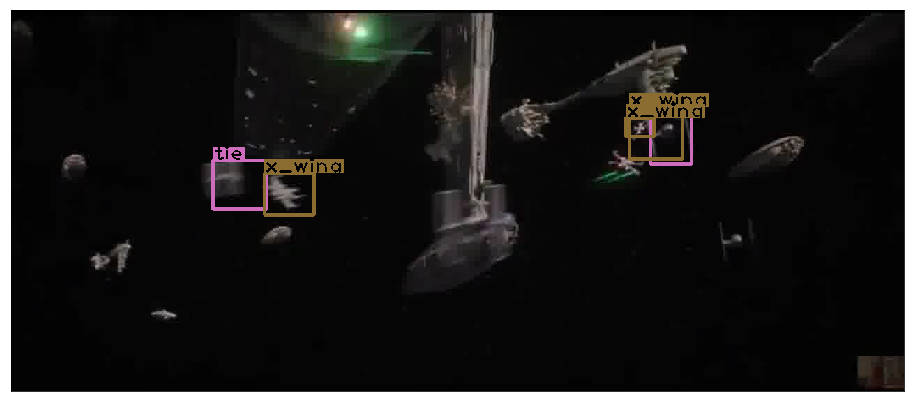

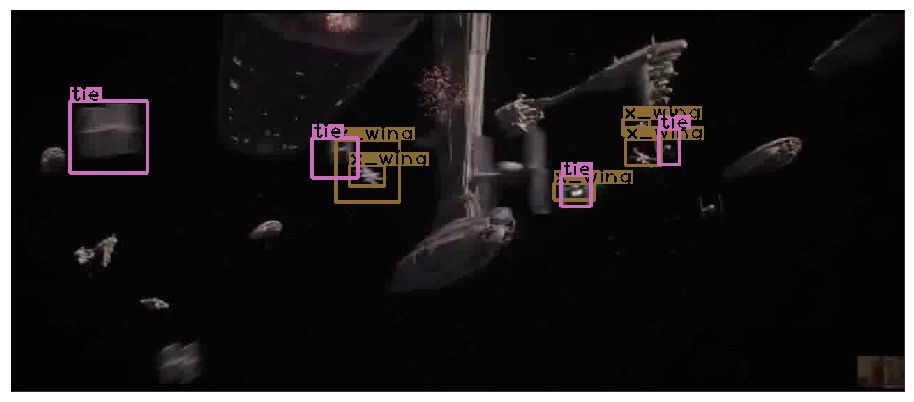

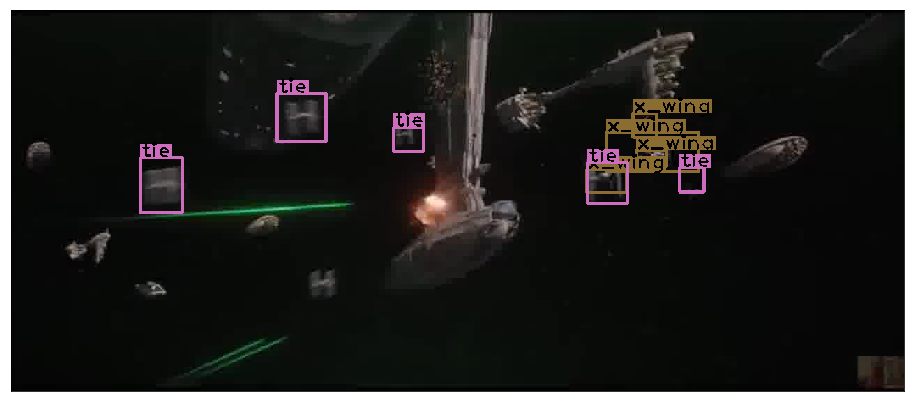

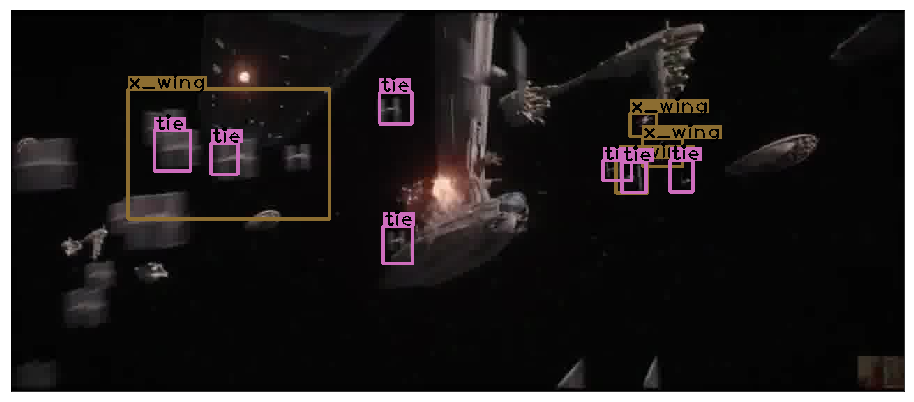

In [6]:
test_model('x_wing_2', classes_names)